In [1]:
import pystan
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import stanity

In [2]:
sns.set(rc={'figure.figsize':(14, 10)})

In [3]:
df = pd.read_csv('data/linearRegression_crimePunishment.csv', index_col=0)

In [4]:
df

,year,stateName,murder,car,law,state
1,1960,Connecticut,0.470004,4.865224,1,1
2,1961,Connecticut,0.000000,4.873669,1,1
3,1962,Connecticut,0.262364,4.984976,1,1
4,1963,Connecticut,0.587787,5.214392,1,1
5,1964,Connecticut,0.587787,5.331268,1,1
...,...,...,...,...,...,...
536,2009,West Virginia,1.526056,5.020586,0,10
537,2010,West Virginia,1.131402,4.870607,0,10
538,2011,West Virginia,1.547563,4.732684,0,10
539,2012,West Virginia,1.335001,4.789989,0,10


## 18.1.1

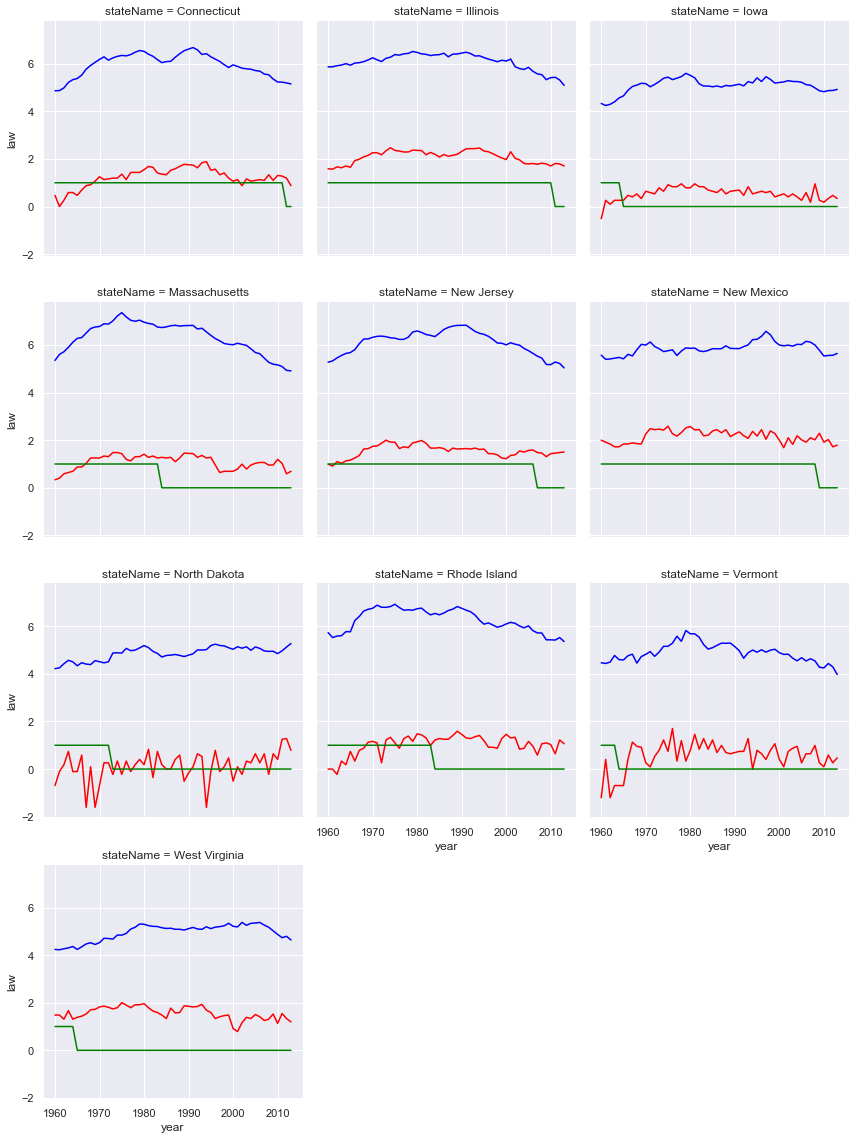

In [5]:
g = sns.FacetGrid(data=df, col='stateName', col_wrap=3, height=4)
g.map(sns.lineplot, 'year', 'murder', color='red')
g.map(sns.lineplot, 'year', 'car', color='blue')
g.map(sns.lineplot, 'year', 'law', color='green')
g.add_legend()

### 18.1.2

In [6]:
ocode = '''
data {
    int N;
    real murder[N];
    real car[N];
    int<lower=0, upper=1> penalty[N];
}

parameters {
    real alpha;
    real b_penalty;
    real b_car;
    real sigma;
}

model {
   for(i in 1:N){
       murder[i] ~ normal(alpha+b_car*car[i]+b_penalty*penalty[i], sigma);
   }
   
   alpha ~ normal(0,1);
   b_penalty ~ normal(0,1);
   b_car ~ normal(0,1);
   sigma ~ normal(0,1);
}

generated quantities{
    real logLikelihood[N];
    for(i in 1:N)
        logLikelihood[i] = normal_lpdf(murder[i] | alpha+b_car*car[i]+b_penalty*penalty[i], sigma);
}

'''
sm = pystan.StanModel(model_code=ocode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd649e4999a89f3b5acbe58311a96fec NOW.


In [7]:
data = {
    'N': df.shape[0],
    'murder': df.murder, 
    'car': df.car,
    'penalty': df.law
}

In [8]:
fit = sm.sampling(data=data, iter=1000, chains=4, seed=1)
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_bd649e4999a89f3b5acbe58311a96fec.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha              -1.49    0.01   0.23  -1.96  -1.63  -1.49  -1.35  -1.06    434    1.0
b_penalty           0.24  1.9e-3   0.06   0.12    0.2   0.24   0.28   0.35   1020    1.0
b_car               0.45  1.8e-3   0.04   0.37   0.43   0.45   0.48   0.54    526    1.0
sigma               0.62  5.3e-4   0.02   0.59   0.61   0.62   0.64   0.66   1347    1.0
logLikelihood[1]   -0.75  2.8e-3   0.08  -0.91   -0.8  -0.75   -0.7  -0.62    741    1.0
logLikelihood[2]   -1.64  5.8e-3   0.15  -1.95  -1.74  -1.63  -1.53  -1.34    704    1.0
logLikelihood[3]   -1.17  4.0e-3   0.11  -1.39  -1.24  -1.17   -1.1  -0.96    734    1.0
logLikelihood[4]    -0.8  2.3e-3   0.07  -0.94  -0.85   -0.8 

In [9]:
loo1 = stanity.psisloo(fit.extract()['logLikelihood'])
loo1.elpd

-512.7884175247236

### 18.1.3

In [10]:
ocode = '''
data {
    int N;
    int K_states;
    real murder[N];
    real car[N];
    int states[N];
    int<lower=0, upper=1> penalty[N];
}

parameters {
    real alpha[K_states];
    real b_penalty[K_states];
    real b_car[K_states];
    real<lower=0> sigma[K_states];
    real alpha_hat;
    real<lower=0> sigma_alpha;
    real b_penalty_hat;
    real<lower=0> sigma_b_penalty;
    real b_car_hat;
    real<lower=0> sigma_b_car;
}

model {
   for(i in 1:N){
       int k;
       k = states[i];
       murder[i] ~ normal(alpha[k]+b_car[k]*car[i]+b_penalty[k]*penalty[i], sigma[k]);
   }
   
   alpha ~ normal(alpha_hat, sigma_alpha);
   b_penalty ~ normal(b_penalty_hat, sigma_b_penalty);
   b_car ~ normal(b_car_hat, sigma_b_car);
   
   alpha_hat ~ normal(0,1);
   sigma_alpha ~ normal(0,1);
   b_penalty_hat ~ normal(0,1);
   sigma_b_penalty ~ normal(0,1);
   b_car_hat ~ normal(0,1);
   sigma_b_car ~ normal(0,1);
   sigma ~ normal(0,1);
}

generated quantities{
    real logLikelihood[N];
    real alpha_avg;
    real b_car_avg;
    real b_penalty_avg;
    alpha_avg = normal_rng(alpha_hat, sigma_alpha);
    b_car_avg = normal_rng(b_car_hat, sigma_b_car);
    b_penalty_avg = normal_rng(b_penalty_hat, sigma_b_penalty);
    
    
    for(i in 1:N){
        int k;
        k = states[i];
        logLikelihood[i] = normal_lpdf(murder[i] | alpha[k]+b_car[k]*car[i]+b_penalty[k]*penalty[i], sigma[k]);
    }
}

'''
sm = pystan.StanModel(model_code=ocode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b13a66250d88d101b521c83aecebc0c NOW.


In [11]:
data = {
    'N': df.shape[0],
    'K_states': df.state.max(),
    'murder': df.murder.values, 
    'car': df.car.values,
    'penalty': df.law.values,
    'states': df.state.values,
}

In [12]:
fit = sm.sampling(data=data, iter=1000, chains=4, seed=1)
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_8b13a66250d88d101b521c83aecebc0c.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                    mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]           -2.16    0.01   0.39   -2.95  -2.43  -2.16  -1.89  -1.42    870    1.0
alpha[2]           -1.62    0.01   0.37   -2.34  -1.87  -1.62  -1.37  -0.91    959    1.0
alpha[3]           -1.88    0.01   0.43   -2.77  -2.15  -1.89  -1.59  -1.04   1129    1.0
alpha[4]           -1.35  7.7e-3   0.27   -1.88  -1.53  -1.34  -1.17  -0.82   1213   1.01
alpha[5]           -1.14  8.4e-3    0.3   -1.71  -1.34  -1.14  -0.93  -0.54   1277    1.0
alpha[6]            -0.6    0.02   0.54   -1.58  -0.96  -0.64  -0.25   0.53    922    1.0
alpha[7]           -1.85    0.02   0.61   -2.99  -2.25   -1.9  -1.49  -0.57    910   1.01
alpha[8]            -2.1    0.01   0.42   -2.95  -2.3

In [13]:
loo2 = stanity.psisloo(fit.extract()['logLikelihood'])
loo2.elpd

-59.540068043261954

In [16]:
stanity.loo_compare(loo1, loo2)

{'diff': 453.2483494814617, 'se_diff': 19.54810435694031}